# Lecture 10 - Cavity-QED in the dispersive regime

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johannson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [271]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (SolverOptions, about, basis, coherent, correlation_2op_1t,
                   destroy, expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)

%matplotlib inline

# Introduction

**A qubit-resonator system** can described by the Hamiltonian

$$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2} \omega_q \sigma_z + g (a^\dagger + a) \sigma_x$$

where $\omega_r$ and $\omega_q$ <u>are the the bare frequencies(原始频率) of the resonator and qubit</u>, respectively, and where $g$ <u>is the dipole interaction strength</u>. 

*The dispersive regime* <u>occurs when the resonator and qubit is far off resonance</u>, $\Delta \gg g$, where $\Delta = \omega_r-\omega_q$ <u>is the detuning(失谐) between the resonator and the qubit</u> (for example $\omega_r \gg \omega_q$).

In the dispersive regime the system can be described by **an effective Hamiltonian** on the form

$$\displaystyle H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi (a^\dagger a  + 1/2) \sigma_z$$

where **$\chi = g^2/\Delta$** . We can view **the last term** <u>as a correction of the resonator frequency that depends on the qubit state, or a correction to the qubit frequency that depends on the resonator state.</u>
> So the case of correction depends, right? But depends on what? Whether $\omega_r \gg \omega_q$ or its inverse case?

In a beautiful experiment by *D. I. Schuster et al*., **the dispersive regime** <u>was used to resolving the photon number states of a microwave resonator</u> *by monitoring a qubit that was coupled to the resonator.* This notebook shows **how to simulate this kind of system numerically in QuTiP.**

### References

 * [D. I. Schuster et al., Resolving photon number states in a superconducting circuit, Nature 445, 515 (2007)](http://dx.doi.org/10.1038/nature05461)

## Parameters

In [272]:
N = 20

wr = 2.0 * 2 * np.pi  # resonator frequency
wq = 3.0 * 2 * np.pi  # qubit frequency
chi = 0.025 * 2 * np.pi  # parameter in the dispersive hamiltonian

delta = abs(wr - wq)  # detuning
g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

In [273]:
delta, g

(6.283185307179586, np.float64(0.99345882657961))

In [274]:
# compare detuning and g, the first should be much larger than the second
delta / (2 * np.pi), g / (2 * np.pi)

(1.0, np.float64(0.15811388300841897))

In [275]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

Id = tensor(qeye(N), qeye(2))   # Identity matrix, dims=[[20, 2], [20, 2]], shape=(40, 40)

In [276]:
# a   
# dims=[[20, 2], [20, 2]], shape=(40, 40)

In [277]:
# sm   
# dims=[[20, 2], [20, 2]], shape=(40, 40)

In [278]:
# dispersive hamiltonian
H = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi * \
    (a.dag() * a + Id / 2) * sz

Try different **initial state of the resonator**, and see how **the spectrum** further down in the notebook <u>reflects the photon distribution</u> chosen here.

In [279]:
# psi0 = tensor(coherent(N, np.sqrt(6)), (basis(2,0)+basis(2,1)).unit())

In [280]:
# psi0 = tensor(thermal_dm(N, 3), ket2dm(basis(2,0)+basis(2,1))).unit()

In [ ]:
psi0 = tensor(coherent(N, np.sqrt(4)), (basis(2, 0) + basis(2, 1)).unit())

In [ ]:
# psi0 = tensor(coherent(N, np.sqrt(12)), (basis(2, 0) + basis(2, 1)).unit())

## Time evolution

In [283]:
tlist = np.linspace(0, 250, 1000)

In [284]:
res = mesolve(H, psi0, tlist, [], [], options=SolverOptions(nsteps=5000))

### Excitation numbers

We can see that **the systems** <u>do not exchange any energy</u>, *because of they are **off resonance** with each other*.

In [285]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

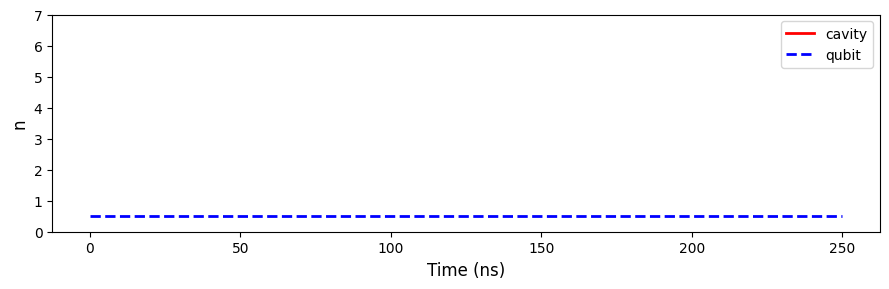

In [286]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9, 3))

ax.plot(tlist, nc_list, "r", linewidth=2, label="cavity")
ax.plot(tlist, nq_list, "b--", linewidth=2, label="qubit")
ax.set_ylim(0, 7)
ax.set_ylabel("n", fontsize=12)
ax.set_xlabel("Time (ns)", fontsize=12)
ax.legend()

fig.tight_layout()

### Resonator quadrature

However, **the quadratures of the resonator** <u>are oscillating rapidly</u>.

In [287]:
xc_list = expect(xc, res.states)  # xc is one of cavity operators 

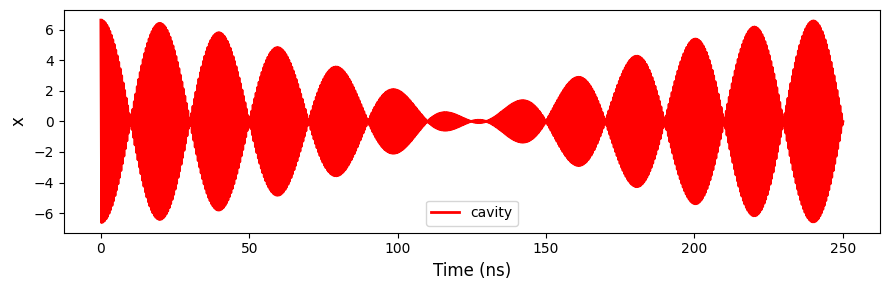

In [288]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9, 3))

ax.plot(tlist, xc_list, "r", linewidth=2, label="cavity")
ax.set_ylabel("x", fontsize=12)
ax.set_xlabel("Time (ns)", fontsize=12)
ax.legend()

fig.tight_layout()

### Correlation function for the resonator

In [289]:
tlist = np.linspace(0, 100, 1000)

In [290]:
corr_vec = correlation_2op_1t(H, psi0, tlist, [], a.dag(), a)

In [291]:
corr_vec   # its imaginary part is always 0

array([ 11.95001133+0.00000000e+00j,   3.67800278+1.13683667e+01j,
        -9.68061382+6.99623525e+00j,  -9.63046251-7.05261964e+00j,
         3.74247977-1.13239775e+01j,  11.91286394+7.49266420e-02j,
         3.59083583+1.13420203e+01j,  -9.67036225+6.89665535e+00j,
        -9.52076645-7.06470799e+00j,   3.78298483-1.12094187e+01j,
        11.80165891+1.48460299e-01j,   3.4824045 +1.12448238e+01j,
        -9.59923603+6.75525395e+00j,  -9.35276132-7.03168485e+00j,
         3.79839299-1.10257021e+01j,  11.61710492+2.19222478e-01j,
         3.35426347+1.10771158e+01j,  -9.46715593+6.57366526e+00j,
        -9.12804911-6.95302954e+00j,   3.78774887-1.07742772e+01j,
        11.36037814+2.85863556e-01j,   3.2080813 +1.08396885e+01j,
        -9.27443899+6.35376867e+00j,  -8.84858454-6.82852381e+00j,
         3.75027788-1.04570199e+01j,  11.0331145 +3.47076893e-01j,
         3.04562447+1.05337834e+01j,  -9.02179955+6.09767222e+00j,
        -8.51665923-6.65825760e+00j,   3.6853963 -1.00762185e+

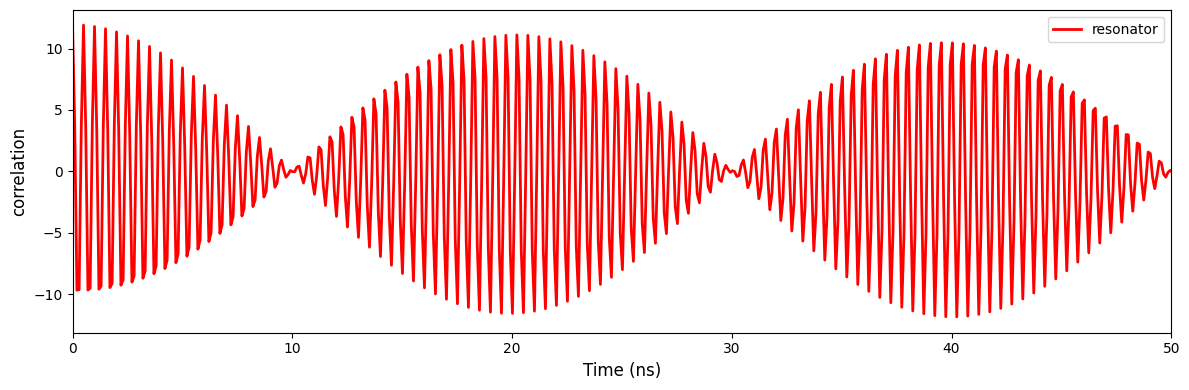

In [292]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, np.real(corr_vec), "r", linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=12)
ax.set_xlabel("Time (ns)", fontsize=12)
ax.legend()
ax.set_xlim(0, 50)
fig.tight_layout()

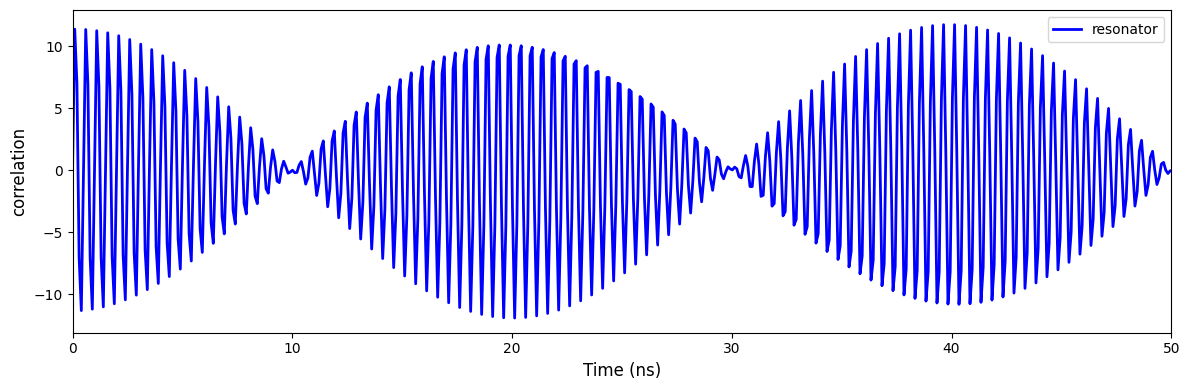

In [293]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, np.imag(corr_vec), "b", linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=12)
ax.set_xlabel("Time (ns)", fontsize=12)
ax.legend()
ax.set_xlim(0, 50)
fig.tight_layout()

### Spectrum of the resonator

In [294]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

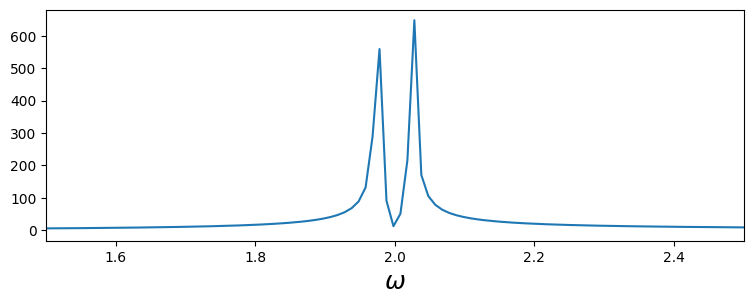

In [295]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(w / (2 * np.pi), abs(S))
ax.set_xlabel(r"$\omega$", fontsize=18)
ax.set_xlim(wr / (2 * np.pi) - 0.5, wr / (2 * np.pi) + 0.5);  # `set_xlim`: Set the x-axis view limits.

>Here we can see <u>how the resonator peak is split and shiften up and down</u> *due to the superposition of 0 and 1 states of the qubit!*<br>


<br>We can <u>also verify that the splitting is exactly</u> $2\chi$, where $\chi = 0.025 * 2 * \pi$ , as expected:

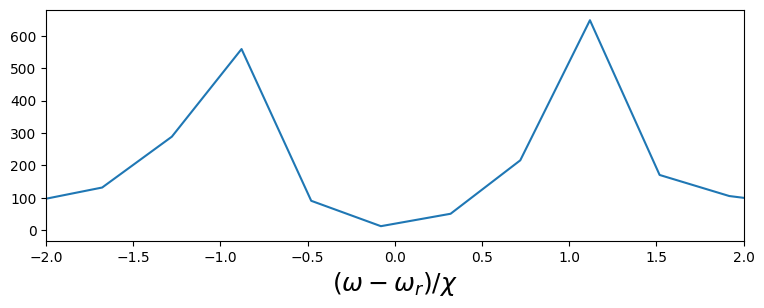

In [296]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot((w - wr) / chi, abs(S))
ax.set_xlabel(r"$(\omega-\omega_r)/\chi$", fontsize=18)
ax.set_xlim(-2, 2);

### Correlation function of the qubit

In [297]:
corr_vec = correlation_2op_1t(H, psi0, tlist, [], sx, sx)

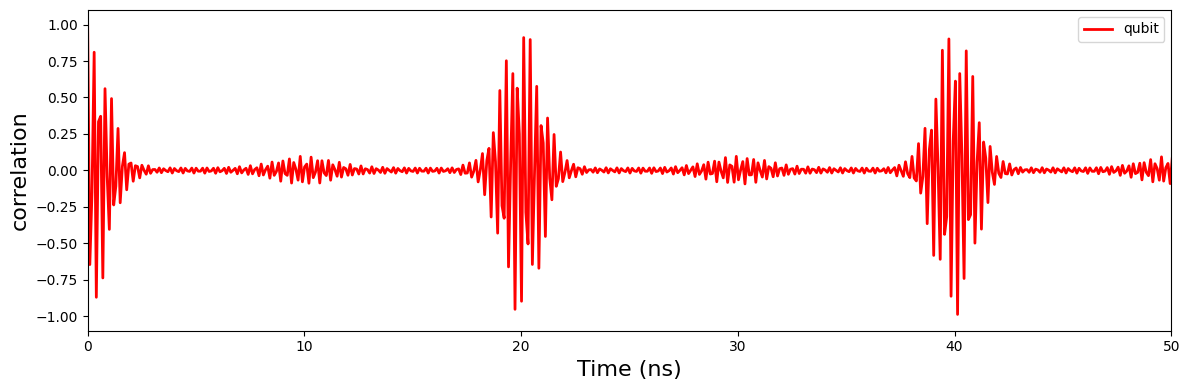

In [298]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, np.real(corr_vec), "r", linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0, 50)
fig.tight_layout()

### Spectrum of the qubit

**The spectrum of the qubit** has an interesting structure: from it one can see **the photon distribution in the resonator mode**!

In [299]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

Text(0.5, 0, '$\\omega$')

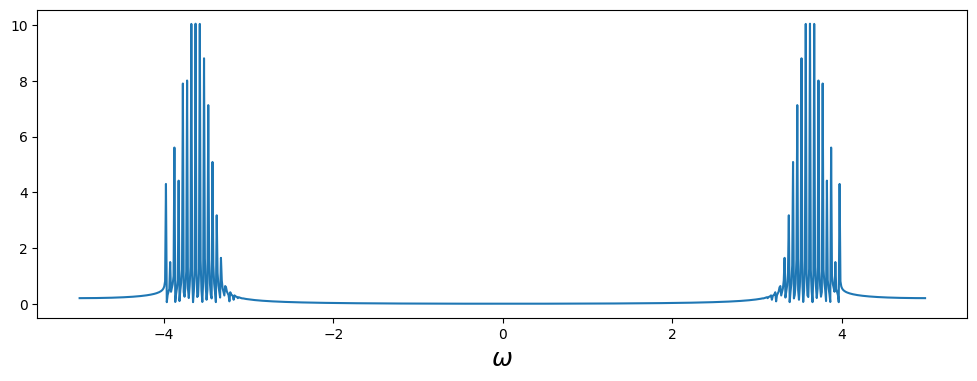

In [300]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(w / (2 * np.pi), abs(S))
ax.set_xlabel(r"$\omega$", fontsize=18)

<u>It's a bit clearer</u> *if we shift the spectrum and scale it with $2\chi$*

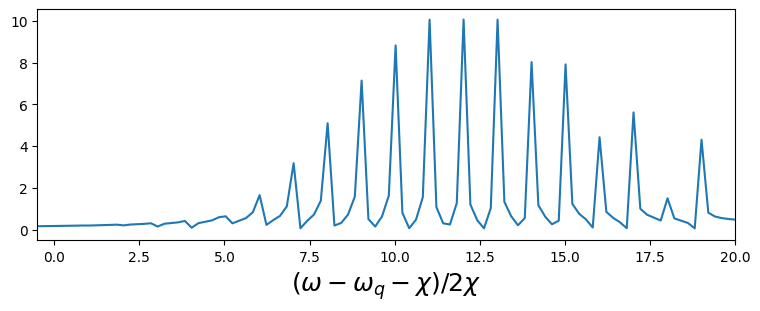

In [301]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot((w - wq - chi) / (2 * chi), abs(S))
ax.set_xlabel(r"$(\omega - \omega_q - \chi)/2\chi$", fontsize=18)
ax.set_xlim(-0.5, N);

Compare to **the cavity fock state distribution**:

In [302]:
rho_cavity = ptrace(res.states[-1], 0)

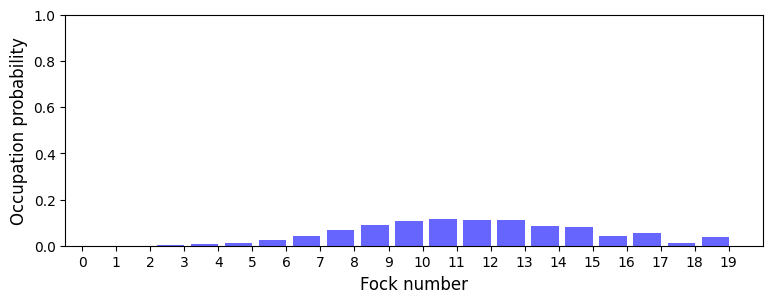

In [303]:
fig, axes = plt.subplots(1, 1, figsize=(9, 3))

axes.bar(np.arange(0, N) - 0.4, np.real(rho_cavity.diag()), color="blue",   # x: `np.arange(0, N) - 0.4`; height: `np.real(rho_cavity.diag()`
         alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(np.arange(0, N))
axes.set_xlabel("Fock number", fontsize=12)
axes.set_ylabel("Occupation probability", fontsize=12);

And *if we look at **the cavity wigner function*** we can see that <u>after interacting dispersively with the qubit</u>, **the cavity** <u>is no longer in a coherent state, but in a superposition of coherent states.</u>

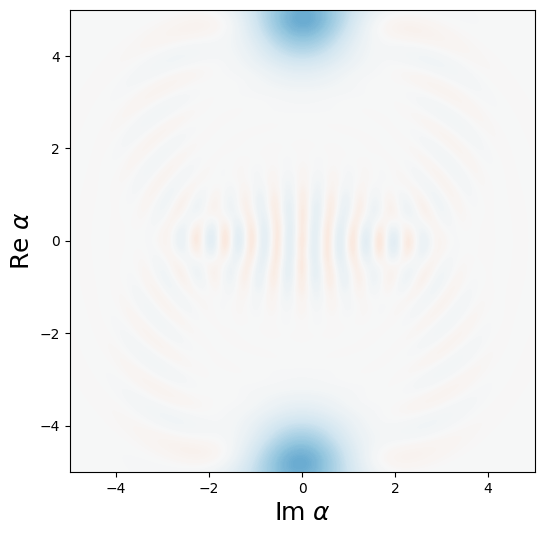

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

xvec = np.linspace(-5, 5, 200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes.set_xlabel(r"Im $\alpha$", fontsize=18)
axes.set_ylabel(r"Re $\alpha$", fontsize=18);

### Software versions

In [305]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0
Numpy Version:      2.3.1
Scipy Version:      1.16.0
Cython Version:     3.1.2
Matplotlib Version: 3.10.3
Python Version:     3.13.5
Number of CPUs:     12
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\13617\miniconda3\envs\qutip_env\Lib\site-packages\qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

Pl